#**Beyblade Battle Analysis: Detection and Application Development**

---------------------

###Install and Import Library

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 10.9 MB/s eta 0:00:00


In [12]:
# Object Detecion
import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

#basics
import pandas as pd
import time
import gdown

###Import Input Video

In [6]:
file_id = '13nDn2l6ydxlnGLyncE7q-5Umlac_jwNe'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'input_video.mp4', quiet=True)

'input_video.mp4'

In [7]:
# Video  path for experiment
path = 'input_video.mp4'

##Import Trained Model

In [8]:
file_id = file_id = '1JdzFsVCURrEnaR3RGiuTJEGFia-P8u2J'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'best.pt', quiet=True)

'best.pt'

In [9]:
# Load trained YOLOv8 model
model = YOLO('/content/best.pt')

##Beyblade Match Analysis and Detection

In [10]:
# Open the input video file
cap = cv2.VideoCapture(path)

# Check total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video
print(f"Total frames in video: {total_frames}")
print(f"Frame rate (FPS): {fps}")

# Calculate the duration of the match in seconds
match_duration = total_frames / fps
print(f"Match duration (seconds): {match_duration:.2f}")

# Define the range of frames to display (1 to total_frames)
start_frame = 1
end_frame = total_frames

# Function to detect beyblades using YOLO model
def detect_beyblades(frame):
    # Run detection using the loaded model
    results = model(frame)
    return results

# Create a list to store the detection data
detection_data = []

# Check if the start frame exceeds the total frame count
if start_frame >= total_frames:
    print(f"Start frame {start_frame} exceeds total frame count ({total_frames}).")
else:
    # Jump to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for frame_number in range(start_frame, end_frame + 1):
        # Read the specific frame
        ret, frame = cap.read()

        if ret:
            # Detect beyblades in the current frame
            results = detect_beyblades(frame)

            # Extract detection data for "beyblade" and "stop" classes
            for detection in results[0].boxes.data.tolist():
                # Extract the class label
                class_label = results[0].names[int(detection[5])]

                # Only process "beyblade" and "stop" classes
                if class_label in ["beyblade", "stop"]:
                    # Extract bounding box coordinates
                    x1, y1, x2, y2 = int(detection[0]), int(detection[1]), int(detection[2]), int(detection[3])

                    # Extract the confidence score
                    confidence = detection[4]

                    # Calculate width of the bounding box
                    width = abs(x2 - x1)

                    # Append detection data to the list
                    detection_data.append([frame_number, class_label, x1, y1, x2, y2, confidence, width])

            # Display the frame
            # annotated_frame = results[0].plot()
            # cv2_imshow(annotated_frame)
            # cv2.waitKey(500)
        else:
            print(f"Failed to retrieve frame {frame_number}.")
            break

# Release video capture object
cap.release()
cv2.destroyAllWindows()

# Create a Pandas DataFrame from the detection data
df = pd.DataFrame(detection_data, columns=["Frame", "Condition", "X1", "Y1", "X2", "Y2", "Confidence", "Width"])

# Replace "beyblade" with "spinning" in the "Condition" column
df['Condition'].replace('beyblade', 'spinning', inplace=True)

# Initialize the "Beyblade Type" and "Status" columns
df['Beyblade Type'] = ''
df['Status'] = ''

# Group by frame and apply logic for Beyblade Type
for frame, group in df.groupby('Frame'):
    if len(group) == 1:
        # Only one detection, set Beyblade Type to empty
        continue
    elif len(group) == 2:
        # Two detections, set types based on width
        max_width_row = group.loc[group['Width'].idxmax()]
        min_width_row = group.loc[group['Width'].idxmin()]
        df.loc[max_width_row.name, 'Beyblade Type'] = 'Beyblade 1'
        df.loc[min_width_row.name, 'Beyblade Type'] = 'Beyblade 2'
    elif len(group) >= 3:
        # Three or more detections, set types based on width, leave middle one empty
        max_width_row = group.loc[group['Width'].idxmax()]
        min_width_row = group.loc[group['Width'].idxmin()]
        df.loc[max_width_row.name, 'Beyblade Type'] = 'Beyblade 1'
        df.loc[min_width_row.name, 'Beyblade Type'] = 'Beyblade 2'
        # The middle detection remains empty

# Count "stop" conditions for each Beyblade type
stop_counts = df[df['Condition'] == 'stop'].groupby('Beyblade Type').size()

# Determine the winner and loser based on stop counts
if 'Beyblade 1' in stop_counts and 'Beyblade 2' in stop_counts:
    if stop_counts['Beyblade 1'] > stop_counts['Beyblade 2']:
        df.loc[df['Beyblade Type'] == 'Beyblade 1', 'Status'] = 'Loser'
        df.loc[df['Beyblade Type'] == 'Beyblade 2', 'Status'] = 'Winner'
    elif stop_counts['Beyblade 2'] > stop_counts['Beyblade 1']:
        df.loc[df['Beyblade Type'] == 'Beyblade 2', 'Status'] = 'Loser'
        df.loc[df['Beyblade Type'] == 'Beyblade 1', 'Status'] = 'Winner'
    else:
        # If they have the same count, you can set a default value or handle it accordingly
        df['Status'] = 'Draw'

# Add match duration to the DataFrame
df['Match Duration for All Frames (seconds)'] = match_duration

# Save the DataFrame to a CSV file
df.to_csv("beyblade_battle_report.csv", index=False)


Total frames in video: 339
Frame rate (FPS): 30.0
Match duration (seconds): 11.30

0: 640x480 2 stops, 3 hands, 330.9ms
Speed: 22.4ms preprocess, 330.9ms inference, 36.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 stops, 3 hands, 358.1ms
Speed: 18.0ms preprocess, 358.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 stops, 4 hands, 151.8ms
Speed: 3.7ms preprocess, 151.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 stops, 3 hands, 152.4ms
Speed: 5.1ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 stop, 3 hands, 343.9ms
Speed: 4.5ms preprocess, 343.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 stop, 2 hands, 232.8ms
Speed: 17.8ms preprocess, 232.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 stops, 3 hands, 153.7ms
Speed: 3.6ms preprocess, 153.7ms inference, 0.9ms postprocess 

Total frames in video: 339

0: 640x480 3 stops, 2 hands, 160.0ms
Speed: 5.7ms preprocess, 160.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


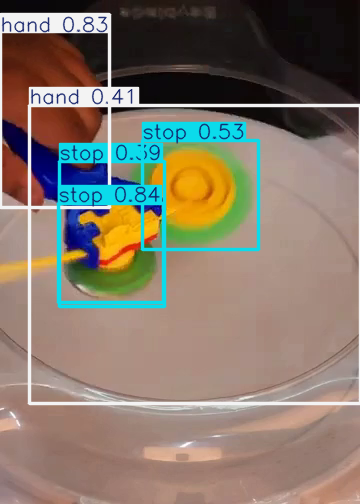


0: 640x480 1 stop, 3 hands, 159.8ms
Speed: 3.9ms preprocess, 159.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


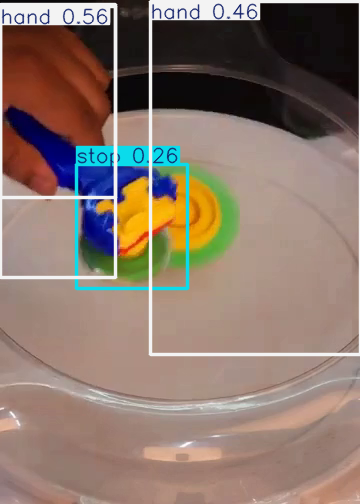


0: 640x480 2 stops, 3 hands, 191.6ms
Speed: 3.9ms preprocess, 191.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


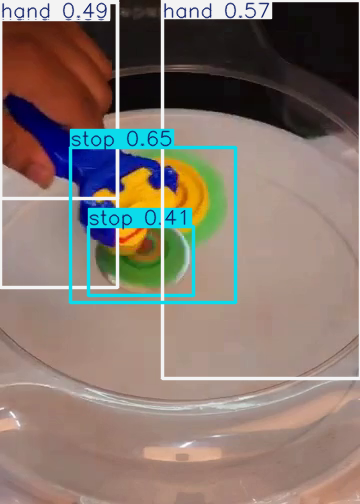


0: 640x480 1 beyblade, 1 stop, 2 hands, 163.0ms
Speed: 4.8ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


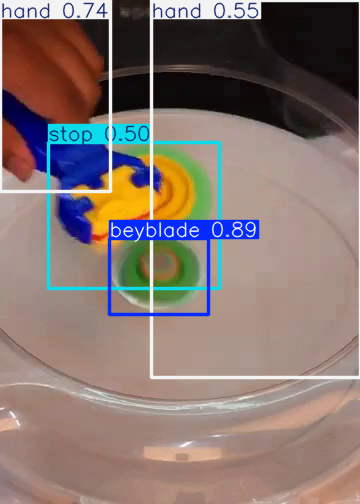


0: 640x480 1 beyblade, 2 hands, 185.7ms
Speed: 4.6ms preprocess, 185.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


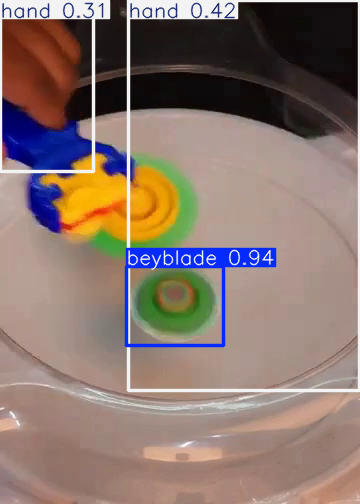


0: 640x480 2 beyblades, 1 hand, 175.2ms
Speed: 4.2ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


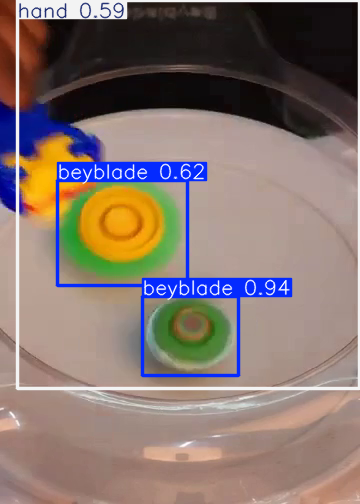


0: 640x480 2 beyblades, 1 hand, 170.6ms
Speed: 4.0ms preprocess, 170.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


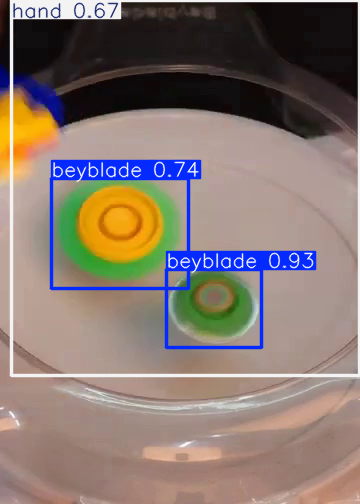


0: 640x480 2 beyblades, 2 hands, 202.8ms
Speed: 4.2ms preprocess, 202.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


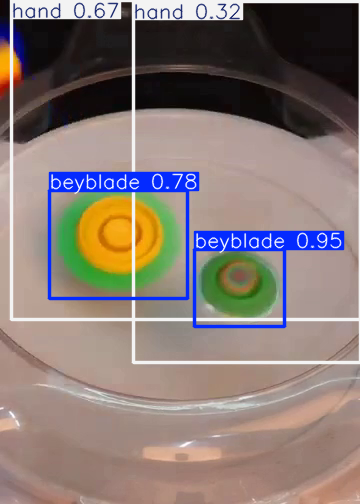


0: 640x480 2 beyblades, 2 hands, 199.1ms
Speed: 3.9ms preprocess, 199.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


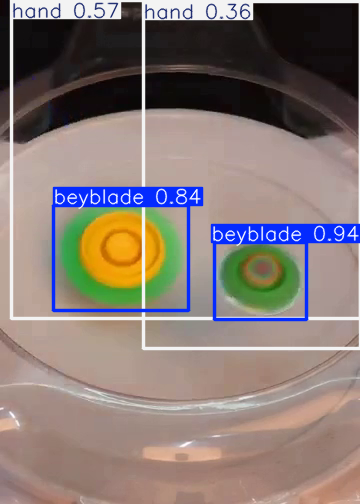


0: 640x480 2 beyblades, 1 hand, 188.9ms
Speed: 3.9ms preprocess, 188.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


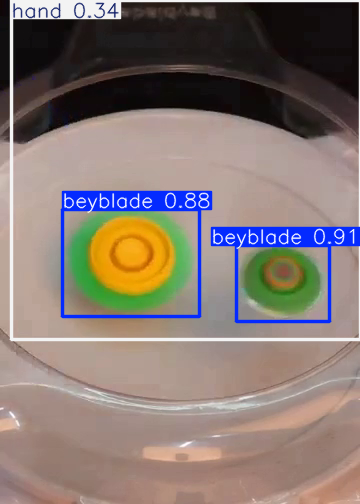


0: 640x480 2 beyblades, 1 hand, 192.6ms
Speed: 3.8ms preprocess, 192.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


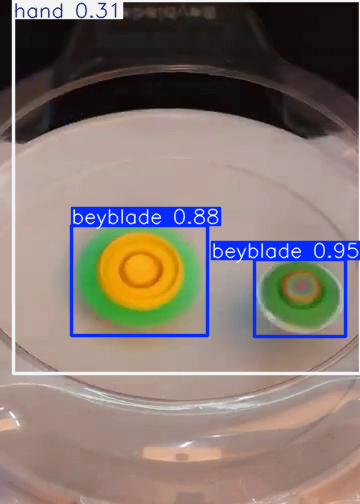

In [16]:
import cv2
from ultralytics import YOLO

# Load your trained YOLOv8 model
model = YOLO('/content/best.pt')

# Open the input video file
cap = cv2.VideoCapture('/content/input_video.mp4')

# Check total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames in video: {total_frames}")

# Define the range of frames to display
start_frame = 10
end_frame = 20

# Function to detect beyblades using YOLO model
def detect_beyblades(frame):
    # Run detection using the loaded model
    results = model(frame)
    return results

# Check if the start frame exceeds the total frame count
if start_frame >= total_frames:
    print(f"Start frame {start_frame} exceeds total frame count ({total_frames}).")
else:
    # Jump to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for frame_number in range(start_frame, end_frame + 1):
        # Read the specific frame
        ret, frame = cap.read()

        if ret:
            # Detect beyblades in the current frame
            results = detect_beyblades(frame)

            # Visualize the detection results by drawing bounding boxes on the frame
            annotated_frame = results[0].plot()

            # Display the frame
            cv2_imshow( annotated_frame)

            # Wait for 500 milliseconds before displaying the next frame
            cv2.waitKey(500)
        else:
            print(f"Failed to retrieve frame {frame_number}.")
            break

# Release video capture object
cap.release()
cv2.destroyAllWindows()
